# rays - Engineered features
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 45 # rays
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrRays].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(10233, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10233 entries, 0 to 10232
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            10233 non-null  int64  
 1   dimCustomerMasterId     10233 non-null  int64  
 2   customerNumber          10231 non-null  object 
 3   year                    10233 non-null  int64  
 4   productGrouping         10233 non-null  object 
 5   totalSpent              10233 non-null  float64
 6   recentDate              10233 non-null  object 
 7   attendancePercent       10233 non-null  float64
 8   renewedBeforeDays       10233 non-null  int64  
 9   isBuyer                 10233 non-null  object 
 10  source_tenure           10233 non-null  int64  
 11  tenure                  10233 non-null  int64  
 12  distToVenue             10233 non-null  float64
 13  totalGames              10233 non-null  int64  
 14  recency                 10233 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = ["year",
            "isNextYear_Buyer",
            "productGrouping",
            "dimCustomerMasterId",
           "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "click_link",
        "open_email",
        "send_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "is_Lockdown",
        "NumberofGamesPerSeason"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (6496, 22)
Unseen Data For Predictions: (1146, 22)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
       "totalSpent",
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "click_link",
        "open_email",
        "send_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio",
        "is_Lockdown",
        "NumberofGamesPerSeason"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8232,0.8833,0.8972,0.8143,0.8537,0.6318,0.6368,0.7730
lr,Logistic Regression,0.6975,0.7669,0.7935,0.7126,0.7507,0.3689,0.3728,0.4730


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8246,0.8673,0.8899,0.8203,0.8537,0.6356,0.6389
1,0.8243,0.8970,0.8770,0.8274,0.8515,0.6368,0.6384
2,0.8225,0.8883,0.9117,0.8050,0.8550,0.6283,0.6364
3,0.8116,0.8673,0.9022,0.7967,0.8462,0.6056,0.6134
4,0.8188,0.8865,0.9054,0.8039,0.8516,0.6212,0.6284
5,0.7880,0.8630,0.8675,0.7857,0.8246,0.5585,0.5629
6,0.8478,0.8907,0.9211,0.8319,0.8743,0.6828,0.6885
7,0.8297,0.8862,0.8991,0.8213,0.8584,0.6459,0.6501
8,0.8514,0.8983,0.9117,0.8426,0.8758,0.6918,0.6951
9,0.8134,0.8890,0.8868,0.8080,0.8456,0.6112,0.6154


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2591, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
7642,45,28368082,100617891,2021,Membership Bronze,2000.0,1970-01-01,0.0,162,TRUE,...,0,0,0.0,1,82,0,0,0,1.0000,0.0000
7643,45,28368755,100163166,2021,Membership Bronze,500.0,1970-01-01,0.0,77,TRUE,...,0,0,0.0,1,82,0,0,0,0.9995,0.0005
7644,45,28368912,10757632,2021,Membership Bronze,500.0,1970-01-01,0.0,154,TRUE,...,0,0,0.0,1,82,0,0,0,0.9999,0.0001
7645,45,28369573,100011476,2021,Membership Bronze,500.0,1970-01-01,0.0,120,TRUE,...,0,0,0.0,1,82,0,0,0,0.9994,0.0006
7646,45,28369935,100127831,2021,Membership Bronze,500.0,1970-01-01,0.0,178,TRUE,...,0,0,0.0,1,82,0,0,0,1.0000,0.0000


In [11]:
new_predictions["Label"].value_counts()

0    2588
1       3
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    2586
(0.4, 0.6]          2
(0.2, 0.4]          1
(0.6, 0.8]          1
(0.8, 1.0]          1
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

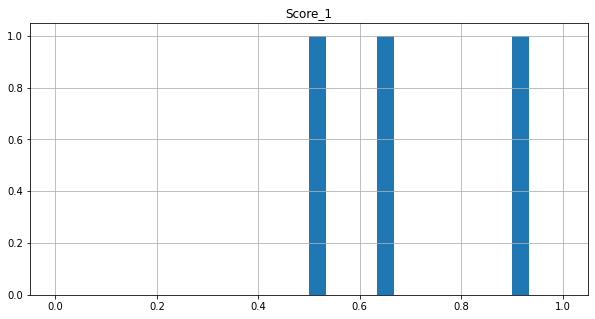

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

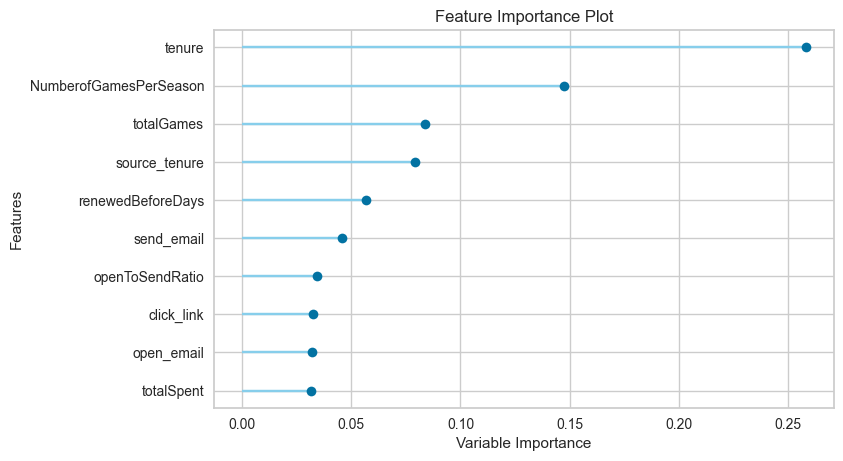

In [14]:
plot_model(best_model, plot='feature')

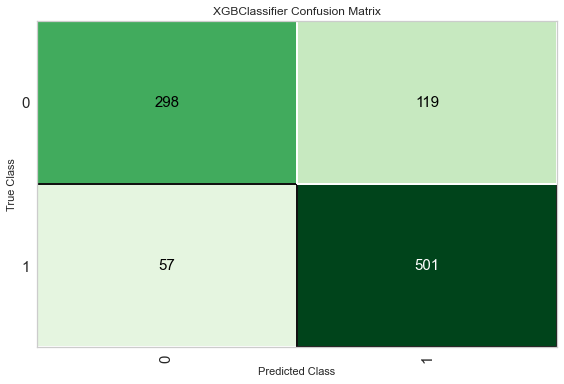

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?